# Time Series Modeling


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

I want to use monthly data so I will quickly download them from my Bybit account

In [ ]:
path1 = "/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/encrypted/bybit_sub_secret.key"
path2 = "/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/encrypted/bybit_sub_encrypted_keys.txt"

In [ ]:
from pybit.unified_trading import HTTP
from encrypted.encryption import load_keys

api_key, api_secret = load_keys(path1, path2)
session = HTTP(
    testnet=False,
    api_key= api_key,
    api_secret = api_secret,
)

print(session.get_server_time())

{'retCode': 0, 'retMsg': 'OK', 'result': {'timeSecond': '1719633732', 'timeNano': '1719633732938531764'}, 'retExtInfo': {}, 'time': 1719633732938}


In [ ]:
from utils.convert_datetime import convert_to_timestamp
from utils.get_data_bybit import get_data_with_volume_bybit

start_date = convert_to_timestamp("2020-01-01")
end_date = convert_to_timestamp("2024-06-01")

Data = get_data_with_volume_bybit(session, "BTCUSD", start_date, end_date, interval = "M", category = "linear", limit = 200, invert = True)
Data.head()

            openPrice  highPrice  lowPrice  closePrice       volume  \
startTime                                                             
2020-01-01     7169.0     9575.0    6854.5      9346.0  27439678684   
2020-02-01     9346.0    10549.5    8441.0      8535.0  24934218621   
2020-03-01     8535.0     9224.0    3730.0      6424.0  30487925547   
2020-04-01     6424.0     9482.5    6155.0      8628.5  24601554461   
2020-05-01     8628.5    10098.5    8088.0      9443.0  39377970876   

                      turnover  symbol  
startTime                               
2020-01-01  3286979.4167106887  BTCUSD  
2020-02-01  2578988.9134525354  BTCUSD  
2020-03-01  4770047.7781243781  BTCUSD  
2020-04-01  3360241.3340457375  BTCUSD  
2020-05-01  4280643.6997844595  BTCUSD  


,openPrice,highPrice,lowPrice,closePrice,volume,turnover,symbol
startTime,,,,,,,
2020-01-01,7169.0,9575.0,6854.5,9346.0,27439678684,3286979.4167106887,BTCUSD
2020-02-01,9346.0,10549.5,8441.0,8535.0,24934218621,2578988.9134525354,BTCUSD
2020-03-01,8535.0,9224.0,3730.0,6424.0,30487925547,4770047.7781243781,BTCUSD
2020-04-01,6424.0,9482.5,6155.0,8628.5,24601554461,3360241.3340457375,BTCUSD
2020-05-01,8628.5,10098.5,8088.0,9443.0,39377970876,4280643.6997844595,BTCUSD


In [ ]:
Data.to_csv('/Users/leonardoplacidi/Desktop/BacktestingTrade/Python4Finance/data/Bybit_BTC_monthly.csv', index=False)

Start decomposing the time series

<Axes: title={'center': 'BTC price'}, xlabel='startTime'>

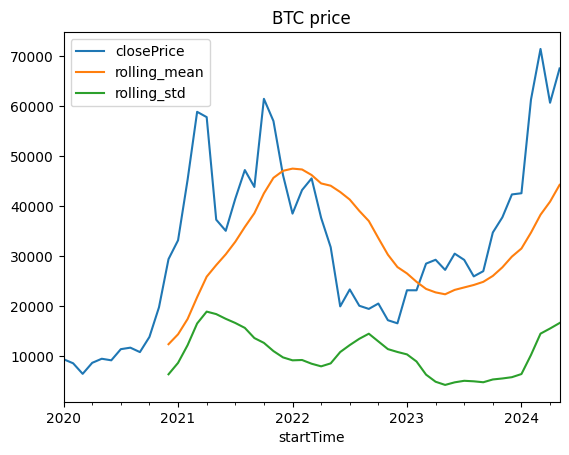

In [ ]:
window = 12

Data["rolling_mean"] = Data.closePrice.rolling(window).mean()
Data["rolling_std"] = Data.closePrice.rolling(window).std()

Data.plot(title = "BTC price", y=['closePrice', 'rolling_mean', 'rolling_std'])

The MA seems like a sin function at this point lol

## Break into multiplicative model
Seasonal decomposition is a technique used to break down a time series into its underlying components: trend, seasonality, and residual (noise). The multiplicative model assumes that these components multiply together to form the observed time series.

In [ ]:
decomposition = seasonal_decompose(Data.closePrice, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

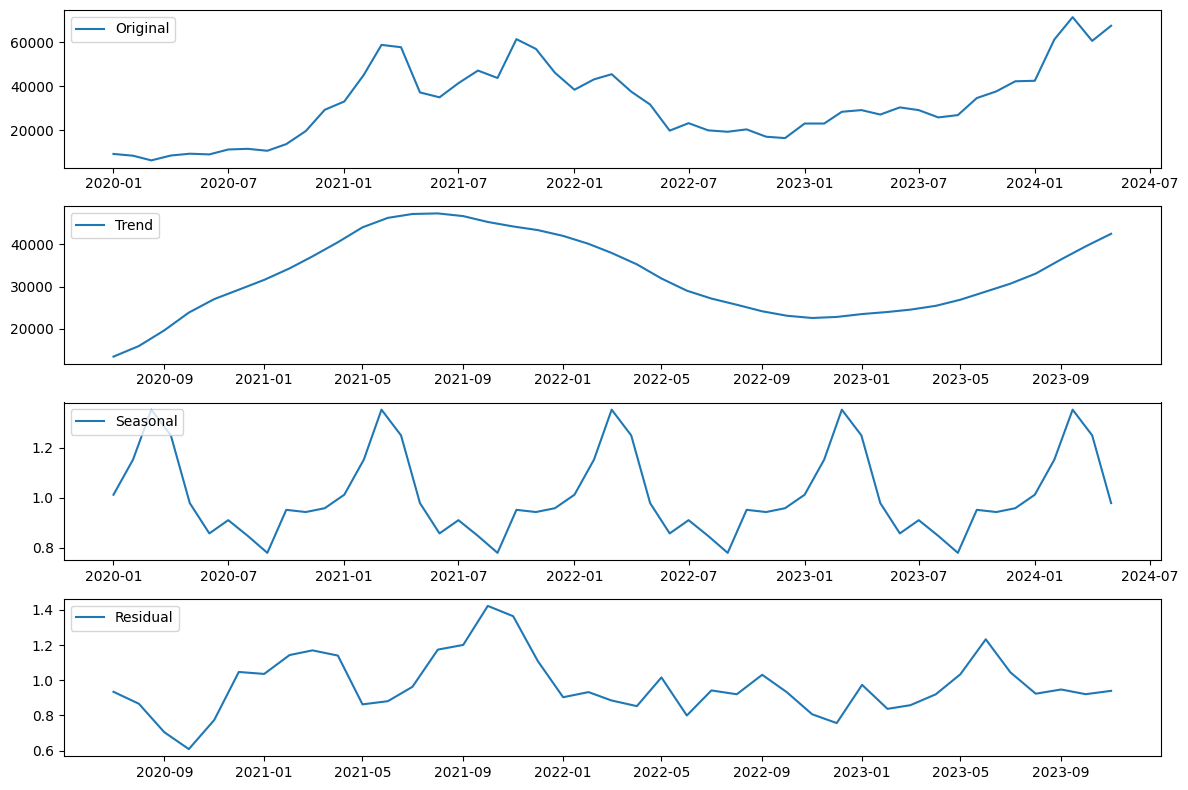

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(Data.closePrice, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

That's pretty mindblowing as it's quite realistic

Let's check out the additive model just for fun :)

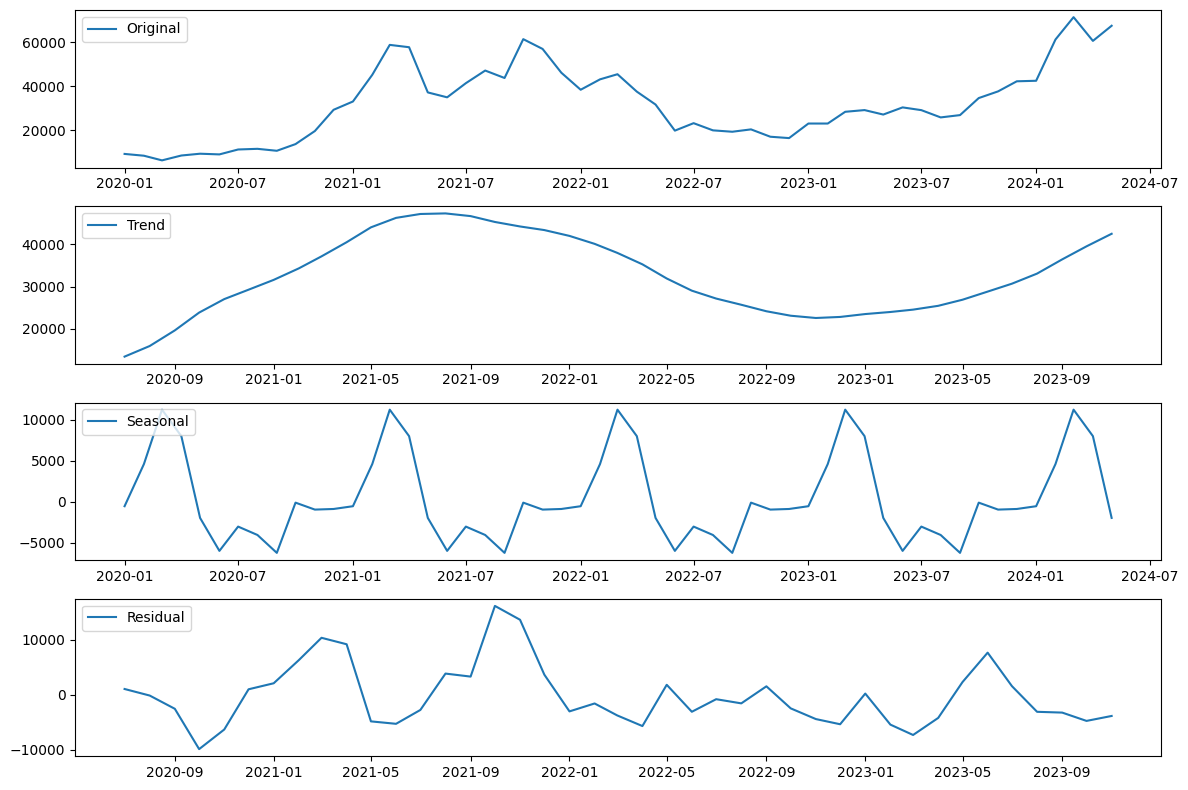

In [ ]:
decomposition = seasonal_decompose(Data.closePrice, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(Data.closePrice, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

both together

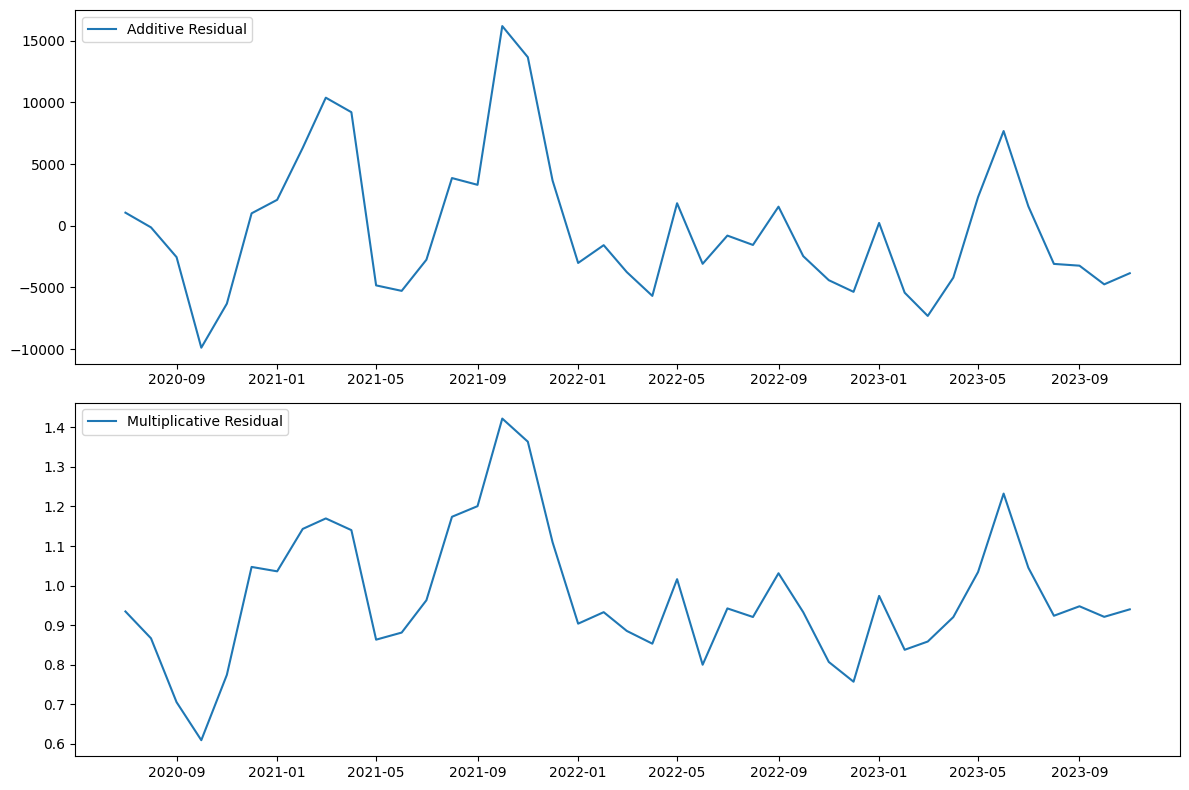

In [ ]:
# Perform additive decomposition
additive_decomposition = seasonal_decompose(Data.closePrice, model='additive')
additive_trend = additive_decomposition.trend
additive_seasonal = additive_decomposition.seasonal
additive_residual = additive_decomposition.resid

# Perform multiplicative decomposition
multiplicative_decomposition = seasonal_decompose(Data.closePrice, model='multiplicative')
multiplicative_trend = multiplicative_decomposition.trend
multiplicative_seasonal = multiplicative_decomposition.seasonal
multiplicative_residual = multiplicative_decomposition.resid

# Plot residuals to compare
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(additive_residual, label='Additive Residual')
plt.legend(loc='upper left')
plt.subplot(212)
plt.plot(multiplicative_residual, label='Multiplicative Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

I cannot decide which is the most random, the are very similarly distributed.

One reason might be that the **seasonal component is relatively regular over time**

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate residuals
additive_residual = additive_decomposition.resid.dropna()
multiplicative_residual = multiplicative_decomposition.resid.dropna()

# Calculate MAE and RMSE
mae_additive = mean_absolute_error(additive_residual, np.zeros_like(additive_residual))
rmse_additive = np.sqrt(mean_squared_error(additive_residual, np.zeros_like(additive_residual)))

mae_multiplicative = mean_absolute_error(multiplicative_residual, np.zeros_like(multiplicative_residual))
rmse_multiplicative = np.sqrt(mean_squared_error(multiplicative_residual, np.zeros_like(multiplicative_residual)))

print(f'Additive Residuals: MAE={mae_additive}, RMSE={rmse_additive}')
print(f'Multiplicative Residuals: MAE={mae_multiplicative}, RMSE={rmse_multiplicative}')


ModuleNotFoundError: No module named 'sklearn'